In [1]:
from simulator import Sim
from base_strategy import BaseStrategy

from stoikov_strategy import StoikovStrategy, FutureStrategy

from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
T = pd.Timedelta(2, 'h').delta

In [2]:
from load_data import load_before_time

In [3]:
lobs = load_before_time(PATH_TO_FILE + 'lobs.csv', T)

names = lobs.columns.values
ln = len('btcusdt:Binance:LinearPerpetual_')
renamer = { name:name[ln:] for name in names[2:]}
renamer[' exchange_ts'] = 'exchange_ts'
lobs.rename(renamer, axis=1, inplace=True)

In [4]:
lobs = lobs[['receive_ts', 'ask_price_0', 'ask_vol_0', 'bid_price_0', 'bid_vol_0']]

In [5]:
lobs = lobs.rename(mapper={col:col[:-2] for col in lobs.columns if col[-1] == '0'}, axis=1)

In [6]:
lobs

,receive_ts,ask_price,ask_vol,bid_price,bid_vol
0,1655942402250125991,19977.5,0.079,19977.4,12.381
1,1655942402657844605,19977.5,0.078,19977.4,12.381
2,1655942403346968722,19977.5,0.079,19977.4,12.381
3,1655942404080791047,19977.5,0.079,19977.4,12.381
4,1655942404452706766,19977.5,0.079,19977.4,12.381
...,...,...,...,...,...
206519,1655949602089731797,20367.0,2.467,20366.9,2.101
206520,1655949602122549162,20367.0,1.459,20366.9,2.391
206521,1655949602157709637,20367.0,1.383,20366.9,3.089
206522,1655949602189840336,20367.0,1.486,20366.9,2.442


In [7]:
lobs['mid_price'] = 0.5 * (lobs['ask_price'] + lobs['bid_price'])
lobs['spread'] = (lobs['ask_price'] - lobs['bid_price'])
lobs['imbalance'] = lobs['bid_vol'] / (lobs['bid_vol'] + lobs['ask_vol']) 

## Делаем данные дискретными

In [8]:
I = lobs['imbalance'].values

In [9]:
n = 11
I_unique = list(range(0, n))

I = (I * n).astype(int)

In [10]:
I_unique

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [11]:
I

array([10, 10, 10, ...,  7,  6,  6])

In [12]:
spread = np.round_(lobs['spread'].values, 4)
max_spread = np.quantile(spread, 0.99)
min_spread = np.min(spread)

S = (np.clip(spread, 0, max_spread) / min_spread).astype(int)

S_unique = sorted(set(S))

In [13]:
print(*sorted(set(S)), sep='  ')

1  2  4  5  6  8  9  10  11  13  15  16  17  18


In [14]:
dM = np.diff(lobs['mid_price'].values)
dM = np.round_(dM, 2)

alpha = 0.01
q1 = np.quantile(dM[dM != 0], alpha)
q2 = np.quantile(dM[dM != 0], 1 - alpha)

q = max(abs(q1), abs(q2))
q1, q2 = -q, q

dM = np.clip(dM, q1, q2)

In [15]:
print(*sorted(set(dM)), sep='  ')

-3.8  -3.75  -3.7  -3.65  -3.6  -3.55  -3.5  -3.45  -3.4  -3.35  -3.3  -3.25  -3.2  -3.15  -3.1  -3.05  -3.0  -2.95  -2.9  -2.85  -2.8  -2.75  -2.7  -2.65  -2.6  -2.55  -2.5  -2.45  -2.4  -2.35  -2.3  -2.25  -2.2  -2.15  -2.1  -2.05  -2.0  -1.95  -1.9  -1.85  -1.8  -1.75  -1.7  -1.65  -1.6  -1.55  -1.5  -1.45  -1.4  -1.35  -1.3  -1.25  -1.2  -1.15  -1.1  -1.05  -1.0  -0.95  -0.9  -0.85  -0.8  -0.75  -0.7  -0.65  -0.6  -0.55  -0.5  -0.45  -0.4  -0.35  -0.3  -0.25  -0.2  -0.15  -0.1  -0.05  0.0  0.05  0.1  0.15  0.2  0.25  0.3  0.35  0.4  0.45  0.5  0.55  0.6  0.65  0.7  0.75  0.8  0.85  0.9  0.95  1.0  1.05  1.1  1.15  1.2  1.25  1.3  1.35  1.4  1.45  1.5  1.55  1.6  1.65  1.7  1.75  1.8  1.85  1.9  1.95  2.0  2.05  2.1  2.15  2.2  2.25  2.3  2.35  2.4  2.45  2.5  2.55  2.6  2.65  2.7  2.75  2.8  2.85  2.9  2.95  3.0  3.05  3.1  3.15  3.2  3.25  3.3  3.35  3.4  3.45  3.5  3.55  3.6  3.65  3.7  3.75  3.8


In [16]:
k = round((q2 - q1) / (0.05)) + 1

In [17]:
dM_unique = np.round(np.linspace(q1, q2, k), 2)

In [18]:
dM_unique

array([-3.8 , -3.75, -3.7 , -3.65, -3.6 , -3.55, -3.5 , -3.45, -3.4 ,
       -3.35, -3.3 , -3.25, -3.2 , -3.15, -3.1 , -3.05, -3.  , -2.95,
       -2.9 , -2.85, -2.8 , -2.75, -2.7 , -2.65, -2.6 , -2.55, -2.5 ,
       -2.45, -2.4 , -2.35, -2.3 , -2.25, -2.2 , -2.15, -2.1 , -2.05,
       -2.  , -1.95, -1.9 , -1.85, -1.8 , -1.75, -1.7 , -1.65, -1.6 ,
       -1.55, -1.5 , -1.45, -1.4 , -1.35, -1.3 , -1.25, -1.2 , -1.15,
       -1.1 , -1.05, -1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 ,
       -0.65, -0.6 , -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25,
       -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,
        0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,
        0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95,  1.  ,  1.05,  1.1 ,
        1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,  1.5 ,  1.55,
        1.6 ,  1.65,  1.7 ,  1.75,  1.8 ,  1.85,  1.9 ,  1.95,  2.  ,
        2.05,  2.1 ,  2.15,  2.2 ,  2.25,  2.3 ,  2.35,  2.4 ,  2.45,
        2.5 ,  2.55,

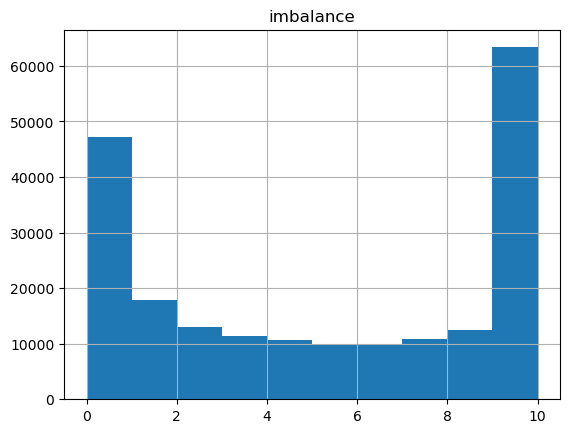

In [19]:
plt.title("imbalance")
plt.hist(I)
plt.grid()
plt.show()

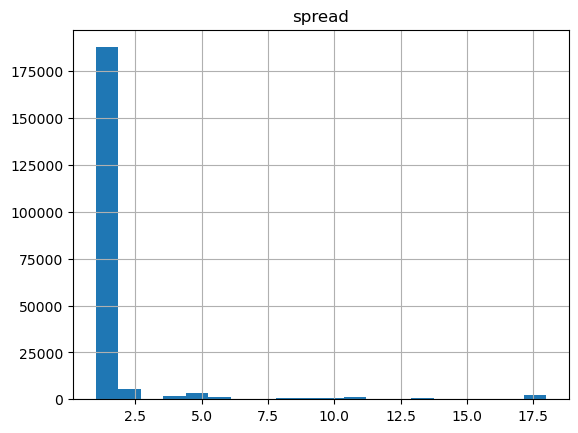

In [20]:
plt.title("spread")
plt.hist(S, bins=20)
plt.grid()
plt.show()

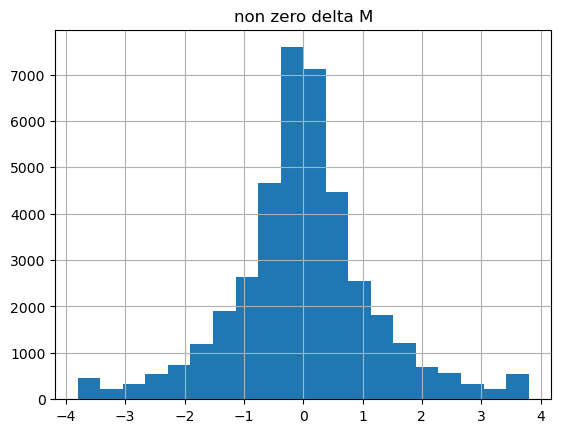

In [21]:
plt.title("non zero delta M")
plt.hist(dM[dM != 0], bins=20)
plt.grid()
plt.show()

In [22]:
n = len(I_unique)
m = len(S_unique)

k = len(dM_unique)

In [23]:
n, m, k

(11, 14, 153)

In [24]:
a = np.ones((n * m, n * m))

## Мапы из значений признака в индес

In [25]:
I_map = dict( zip( I_unique, range(len(I_unique)) ) )

S_map = dict( zip( S_unique, range(len(S_unique)) ) )

dM_map = dict( zip( dM_unique, range(len(dM_unique)) ) )

In [26]:
R = np.zeros((n * m , k))
T = np.zeros((n * m , n * m))
Q = np.zeros((n * m , n * m))

cont = np.zeros((n * m, 1))

In [27]:
N = len(dM)

In [28]:
for idx in range(N):
    
    i, i_ = I[idx], I[idx + 1]
    s, s_ = S[idx], S[idx + 1]
    dm = dM[idx]
    
    x = I_map[i] * m +  S_map[s]
    y = I_map[i_] * m + S_map[s_]
    cont[x] += 1
    j = dM_map[dm]
    if dm != 0.0:
        R[x, j] += 1
        T[x, y] += 1
    else:
        Q[x, y] += 1

    #Symmetrize the data
    i, i_ = n - 1 - I[idx], n - 1 - I[idx + 1]
    dm = -dM[idx]
    
    x = I_map[i] * m +  S_map[s]
    y = I_map[i_] * m + S_map[s_]
    cont[x] += 1
    j = dM_map[dm]
    if dm != 0.0:
        R[x, j] += 1
        T[x, y] += 1
    else:
        Q[x, y] += 1

In [29]:
R = R / (cont + 1e-10)

Q = Q / (cont + 1e-10)

T = T / (cont + 1e-10)

$Q + T$ должна быть стохастической матрицей. Сумма по столбцам иногда даёт ноль, это происходит для тех x, которые ни разу не встречались.

In [30]:
arr = np.sum(Q + T, axis=1)

In [31]:
set(np.round(arr, 4))

{1.0}

In [32]:
Q_inv = np.linalg.inv(np.eye(n * m) - Q)

In [33]:
G = Q_inv @ (R @ dM_unique)

In [34]:
B = Q_inv @ T

In [35]:
n_iter = 100

In [36]:
errors = []
G_star = G
for i in range(n_iter):
    G_star_new = G + B @ G_star
    err = np.linalg.norm(G_star_new - G_star)
    G_star = G_star_new
    print(err)
    errors.append(err)

1.60657998087698
0.6073672949407726
0.2205504159300963
0.07920178334448608
0.028371920281183398
0.0101586951014414
0.0036369756273562956
0.00130206805457954
0.00046614931838090894
0.0001668845082670697
5.974573537518668e-05
2.1389359582064805e-05
7.65752897292685e-06
2.741444859336618e-06
9.81454975857878e-07
3.513672238658165e-07
1.2579173693121411e-07
4.5034254678449224e-08
1.6122554194604925e-08
5.7719788316225864e-09
2.066405516704949e-09
7.397864179400417e-10
2.6484844137177663e-10
9.481736817273438e-11
3.394518101041575e-11
1.215251769234367e-11
4.350942495199078e-12
1.5574366608566984e-12
5.57765868584414e-13
1.995979753764124e-13
7.139238709566908e-14
2.5533777636879292e-14
9.287931277781222e-15
3.642224541091813e-15
2.258892090066262e-15
1.6752576958632216e-15
1.7252247216287544e-15
1.4841275764061088e-15
1.448866893783014e-15
1.4815151518414088e-15
1.6853743943393635e-15
1.5199638836920203e-15
1.6982268420306348e-15
1.579044942434067e-15
1.8571941030070997e-15
1.7691222352071

Видно, что ряд быстро сходится

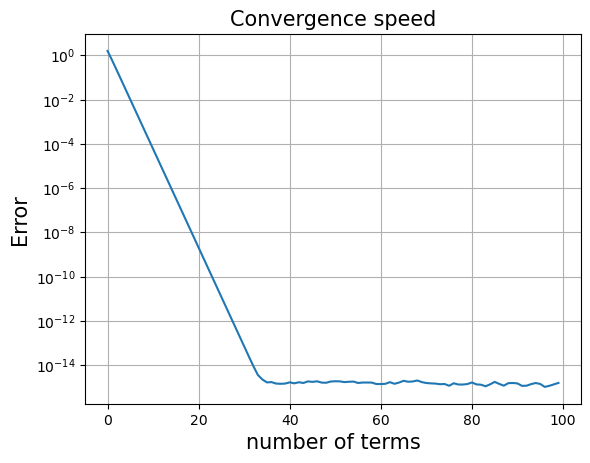

In [37]:
plt.title("Convergence speed", fontsize=15)
plt.semilogy(errors)
plt.ylabel("Error", fontsize=15)
plt.xlabel("number of terms", fontsize=15)
plt.grid()
plt.show()

In [38]:
G_spread = {}
for s in S_unique:
    G_spread[s] = []
    for i in I_unique:
        x = I_map[i] * m +  S_map[s]
        G_spread[s].append( G_star[x] )

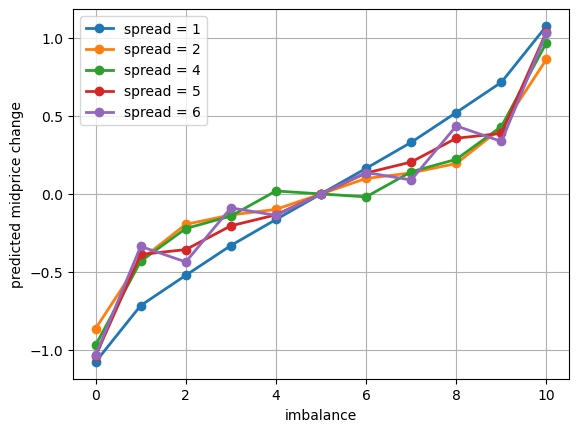

In [39]:
for s in S_unique[:5]:
    plt.plot(I_unique, G_spread[s], '-o', label=f'spread = {s}', linewidth=2)
plt.grid()
plt.legend()
plt.xlabel("imbalance")
plt.ylabel('predicted midprice change')
plt.show()

In [40]:
idx = slice(None, 1000, 10)

In [41]:
dt = pd.to_datetime(lobs.receive_ts)

In [42]:
dM_pred = np.asarray([ G_spread[s][i] for s, i in zip(S, I) ])

In [43]:
np.min(dM_pred)

-1.0780976412049683

In [44]:
np.max(dM_pred)

1.0780976412049914

In [45]:
mid_price = lobs['mid_price'].values

In [46]:
micro_price = mid_price + dM_pred

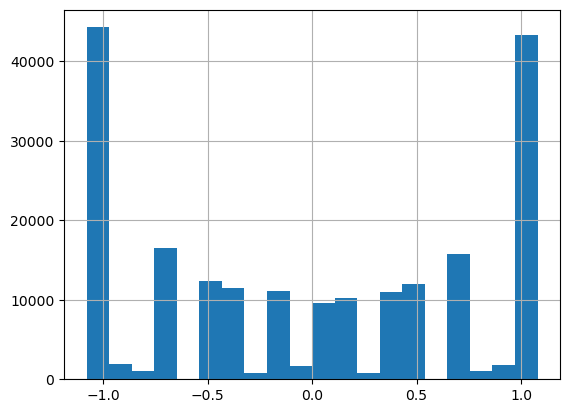

In [47]:
plt.hist(dM_pred, bins=20)
plt.grid()
plt.show()

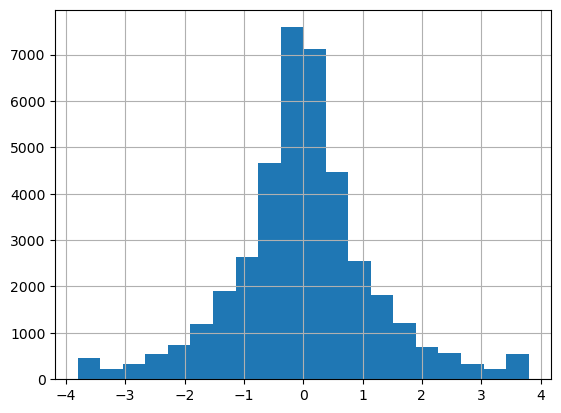

In [48]:
plt.hist(dM[dM != 0.0], bins=20)
plt.grid()
plt.show()

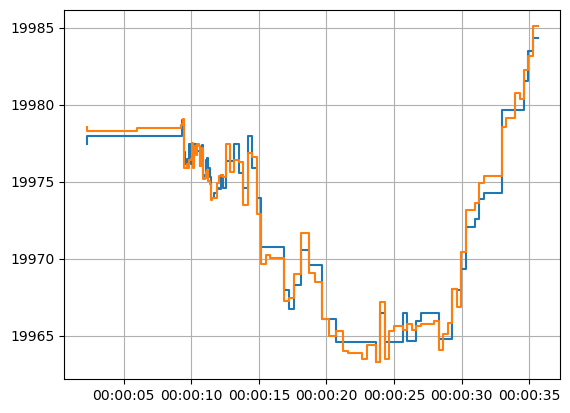

In [49]:
plt.step(dt[idx], mid_price[idx])
plt.step(dt[idx], micro_price[idx])
plt.grid()
plt.show()

In [54]:
!pip3 install --user plotly

In [56]:
from sys import path

In [58]:
path.append('/home/alex/anaconda3/lib/python3.9/site-packages')

In [77]:
idx = slice(None, 10000, 1)

In [79]:
import plotly.express as px

fig = px.line(x=dt[idx], y=mid_price[idx], )
fig.add_scatter(x=dt[idx], y=micro_price[idx])

fig.write_html("mid_micro_price.html")